In [96]:
import os
import json

# Define paths
root_dir = "/content/drive/MyDrive/CODE/VISION/DataSet/DataSet/"
images_dir = os.path.join(root_dir, "images")
annotations_file = os.path.join(root_dir, "annotations.json")
filtered_annotations_file = os.path.join(root_dir, "filtered_annotations.json")

# Load original annotations
with open(annotations_file, "r") as file:
    content = json.load(file)

# Extract images, annotations, and categories
images = content["images"]
annotations = content["annotations"]
categories = content.get("categories", [])

# Get valid category IDs
valid_category_ids = {cat["id"] for cat in categories}

# List actual image files in the dataset folder
existing_images = set(os.listdir(images_dir))

# Track filenames to identify repetitions
seen_files = set()

# Filter images based on file existence
filtered_images = []
valid_image_ids = set()

for img in images:
    file_exists = img["file_name"] in existing_images
    if img["file_name"] in seen_files:
        print(f"Repeated filename detected: {img['file_name']}")
    seen_files.add(img["file_name"])

    if file_exists:
        valid_annotations = [
            {k: v for k, v in ann.items() if k != "segmentation"}
            for ann in annotations
            if ann["image_id"] == img["id"]
            and "bbox" in ann
            and len(ann["bbox"]) == 4
            and ann["category_id"] in valid_category_ids
            and ann["bbox"][2] > 0
            and ann["bbox"][3] > 0
        ]

        if valid_annotations:
            filtered_images.append(img)
            print(f"Included: {img['file_name']}")
        else:
            print(f"No valid annotations: {img['file_name']}")
    else:
        print(f"NA: {img['file_name']}")

# Filter annotations based on filtered images
valid_image_ids = {img["id"] for img in filtered_images}
filtered_annotations = [
    {k: v for k, v in ann.items() if k != "segmentation"}
    for ann in annotations
    if ann["image_id"] in valid_image_ids
    and "bbox" in ann
    and len(ann["bbox"]) == 4
    and ann["bbox"][2] > 0
    and ann["bbox"][3] > 0
    and ann["category_id"] in valid_category_ids
]

# Save the cleaned dataset
filtered_content = {
    "images": filtered_images,
    "annotations": filtered_annotations,
    "categories": categories
}

with open(filtered_annotations_file, "w") as outfile:
    json.dump(filtered_content, outfile, indent=4)

print(f"\n✅ Filtered annotations saved at: {filtered_annotations_file}")

Included: WhatsApp Image 2024-10-22 at 09.10.24.jpeg
Included: WhatsApp Image 2024-10-22 at 09.10.44.jpeg
Included: WhatsApp Image 2024-10-22 at 09.10.45.jpeg
Included: WhatsApp Image 2024-10-22 at 09.10.47.jpeg
Included: WhatsApp Image 2024-10-22 at 09.10.51 (1).jpeg
Included: WhatsApp Image 2024-10-22 at 09.10.51.jpeg
Included: WhatsApp Image 2024-10-22 at 09.10.52.jpeg
Included: WhatsApp Image 2024-10-22 at 09.10.53 (1).jpeg
Included: WhatsApp Image 2024-10-22 at 09.11.10 (2).jpeg
Included: WhatsApp Image 2024-10-22 at 09.11.10 (4).jpeg
Included: WhatsApp Image 2024-10-22 at 09.11.10 (5).jpeg
Included: WhatsApp Image 2024-10-22 at 09.11.10 (6).jpeg
Included: WhatsApp Image 2024-10-22 at 09.11.10.jpeg
Included: WhatsApp Image 2024-10-22 at 14.04.21.jpeg
Included: WhatsApp Image 2024-10-23 at 09.50.20 (2).jpeg
Included: WhatsApp Image 2024-10-23 at 09.50.22 (4).jpeg
Included: WhatsApp Image 2024-10-24 at 09.27.31 (3).jpeg
Included: WhatsApp Image 2024-10-25 at 09.54.25 (5).jpeg
Includ

In [97]:
import torch
from torch.utils.data import Dataset
import os
import cv2 as cv
import json
import albumentations as A
from albumentations.pytorch import ToTensorV2

class OWLv2Dataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        with open(annotation_file, "r") as file:
            content = json.load(file)

        self.images = content["images"]
        self.annotations = content["annotations"]
        self.categories = {cat["id"]: cat["name"] for cat in content["categories"]}

        self.image_id_to_filename = {img["id"]: img["file_name"] for img in self.images}
        self.image_id_to_annotations = {img["id"]: [] for img in self.images}
        for annot in self.annotations:
            self.image_id_to_annotations[annot["image_id"]].append(annot)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_id = img_info["id"]
        img_filename = self.image_id_to_filename.get(img_id, None)

        if img_filename is None:
            print(f"❌ ERROR: Image ID {img_id} has no associated file name!")
            return None

        img_path = os.path.join(self.root_dir, "images", img_filename)

        if not os.path.exists(img_path):
            print(f"⚠️ WARNING: Image file '{img_path}' not found! Skipping this sample.")
            return None

        image = cv.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        width, height = img_info["width"], img_info["height"]

        bboxes = []
        category_ids = []
        for annot in self.image_id_to_annotations.get(img_id, []):
            x, y, w, h = annot["bbox"]
            bboxes.append([x / width, y / height, (x + w) / width, (y + h) / height])
            category_ids.append(annot["category_id"])

        # **Debugging: Print out empty samples**
        if len(bboxes) == 0:
            print(f"⚠️ Skipping image {img_filename} (No bounding boxes found!)")
            return None

        if self.transform:
            transformed = self.transform(image=image, bboxes=bboxes, category_ids=category_ids)
            image = transformed["image"]
            bboxes = torch.tensor(transformed["bboxes"], dtype=torch.float32)
            category_ids = torch.tensor(transformed["category_ids"], dtype=torch.int64)

        return {"pixel_values": image, "labels": {"boxes": bboxes, "class_labels": category_ids}}


Sample Filenames from JSON:
Image ID: 1 -> Filename: WhatsApp Image 2024-10-22 at 09.10.24.jpeg
Image ID: 2 -> Filename: WhatsApp Image 2024-10-22 at 09.10.44.jpeg
Image ID: 3 -> Filename: WhatsApp Image 2024-10-22 at 09.10.45.jpeg
Image ID: 4 -> Filename: WhatsApp Image 2024-10-22 at 09.10.47.jpeg
Image ID: 5 -> Filename: WhatsApp Image 2024-10-22 at 09.10.51 (1).jpeg
Image ID: 6 -> Filename: WhatsApp Image 2024-10-22 at 09.10.51.jpeg


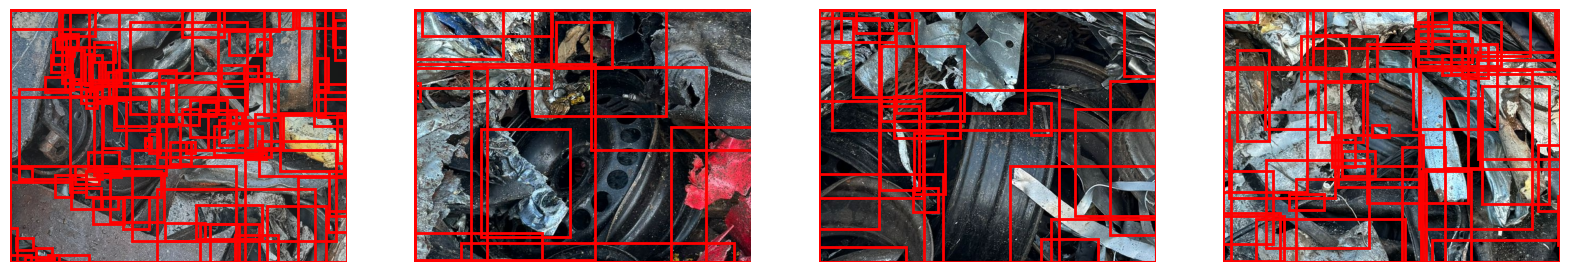

In [98]:
import os
import json
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import Counter
from torch.utils.data import Dataset, DataLoader

# Define paths
root_dir = "/content/drive/MyDrive/CODE/GITHUB/Agave_Vision/data/"
annotations_file = "filtered_annotations.json"
images_dir = os.path.join(root_dir, "images")  # Ensure correct image directory

# Load the dataset
with open(os.path.join(root_dir, annotations_file)) as file:
    content = json.load(file)

# Extract image and annotation details
images = content["images"]
annotations = content["annotations"]

# Create a mapping for image filenames using their IDs
image_id_to_filename = {img["id"]: img["file_name"] for img in images}

# Debugging: Print some filenames to verify
print("Sample Filenames from JSON:")
for i, (img_id, file_name) in enumerate(image_id_to_filename.items()):
    print(f"Image ID: {img_id} -> Filename: {file_name}")
    if i == 5:  # Print only a few samples
        break

# Define DETR augmentation pipeline
transform = A.Compose([
    #A.RandomResizedCrop(height=800, width=800, scale=(0.5, 1.0), ratio=(0.75, 1.33)),  # Random Crop + Resize
    A.HorizontalFlip(p=0.5),  # Random Horizontal Flip
    A.RandomBrightnessContrast(p=0.2),  # Adjust Brightness & Contrast
    A.HueSaturationValue(p=0.2),  # Adjust Hue, Saturation
    A.GaussianBlur(p=0.2),  # Apply Gaussian Blur
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize as per ImageNet standards
    ToTensorV2(),  # Convert to Tensor
], bbox_params=A.BboxParams(format="coco", label_fields=["category_ids"]))


class DETRDataset(Dataset):
    def __init__(self, root_dir, images, annotations, transform=None):
        self.root_dir = root_dir
        self.images = images
        self.annotations = annotations
        self.transform = transform
        self.image_id_to_annotations = self.group_annotations_by_image()

    def group_annotations_by_image(self):
        """
        Groups all annotations by image ID.
        """
        img_annots = {img["id"]: [] for img in self.images}
        for annot in self.annotations:
            img_annots[annot["image_id"]].append(annot)
        return img_annots

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """
        Loads an image and applies augmentation.
        """
        img_info = self.images[idx]
        img_id = img_info["id"]

        # Ensure correct file name mapping
        img_filename = image_id_to_filename.get(img_id, None)
        if img_filename is None:
            raise ValueError(f"Image ID {img_id} has no associated file name!")

        img_path = os.path.join(self.root_dir, "images", img_filename)

        # Read image
        if not os.path.exists(img_path):
            print(f"Warning: Image file '{img_path}' not found! Skipping this sample.")
            return None  # Skip missing images

        image = cv.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # Get bounding boxes & categories
        bboxes = []
        category_ids = []
        for annot in self.image_id_to_annotations[img_id]:
            x, y, w, h = annot["bbox"]
            bboxes.append([x, y, w, h])
            category_ids.append(annot["category_id"])

        # Apply augmentation
        if self.transform:
            transformed = self.transform(image=image, bboxes=bboxes, category_ids=category_ids)
            image = transformed["image"]
            bboxes = transformed["bboxes"]
            category_ids = transformed["category_ids"]

        return image, bboxes, category_ids


# Create dataset
dataset = DETRDataset(root_dir, images, annotations, transform=transform)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Visualize some augmented images
def visualize_augmentations(dataset, num_samples=4):
    """
    Plots augmented images with their bounding boxes.
    """
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

    for i in range(num_samples):
        sample = dataset[i]
        if sample is None:
            continue  # Skip missing images

        image, bboxes, category_ids = sample
        img_np = image.permute(1, 2, 0).numpy()  # Convert to numpy for visualization

        # Denormalize Image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = (img_np * std) + mean  # Reverse normalization
        img_np = np.clip(img_np, 0, 1)

        # Plot
        axes[i].imshow(img_np)
        for bbox in bboxes:
            x, y, w, h = bbox
            rect = plt.Rectangle((x, y), w, h, fill=False, color="red", linewidth=2)
            axes[i].add_patch(rect)
        axes[i].axis("off")

    plt.show()

# Show augmented samples
visualize_augmentations(dataset)


In [99]:
from torch.utils.data import random_split

# Define split ratios
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"✅ Training Set: {len(train_dataset)} samples")
print(f"✅ Testing Set: {len(test_dataset)} samples")


✅ Training Set: 70 samples
✅ Testing Set: 18 samples


In [138]:
# Example: define class name queries for COCO (simplified)
coco_categories = [cat['name'] for cat in coco.loadCats(coco.getCatIds())]  # list of category names
text_queries = [[name for name in coco_categories]]  # as a batch of queries (one list per image)


In [ ]:
# Install required packages
#!pip install torch torchvision transformers pycocotools

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from torchvision.transforms import Compose, PILToTensor, Resize
from transformers import Owlv2Processor, Owlv2ForObjectDetection
from pycocotools.coco import COCO
import torch.optim as optim

# GPU setup
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# Paths
image_dir = '/content/drive/MyDrive/CODE/GITHUB/Agave_Vision/data/images'
annotations_file = '/content/drive/MyDrive/CODE/GITHUB/Agave_Vision/data/filtered_annotations.json'

# Load OWLv2 processor and model
processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble").to(device)

# Enable gradient checkpointing
model.gradient_checkpointing_enable()

# Define your categories
class_names = [
    "steel_other_thick", "steel_wire_thick", "steel_sheet_thick", "steel_brakedisc",
    "steel_structural", "steel_tube_thick", "steel_rebar", "steel_rim",
    "steel_chain", "motor", "steel_radiator", "steel_other_thin",
    "steel_wire_thin", "steel_tube_thin_rectangular", "steel_tube_thin", "steel_cylinder",
    "steel_meshsheet", "steel_can", "plastic_rigid", "plastic_foam",
    "plastic_flexible", "rubber", "wood", "textile", "dust", "concrete",
    "steel_sheet_thin", "other_contaminant", "steel_tank", "HMS1&2_(too far to distinguish)"
]

# Dataset transformation
transform = Compose([Resize((400, 400)), PILToTensor()])

class CustomCocoDataset(CocoDetection):
    def __getitem__(self, idx):
        img, anns = super().__getitem__(idx)
        boxes, labels = [], []
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x+w, y+h])
            labels.append(ann['category_id'])
        target = {"boxes": torch.tensor(boxes, dtype=torch.float32),
                  "labels": torch.tensor(labels, dtype=torch.int64),
                  "image_id": torch.tensor([self.ids[idx]])}
        return img, target

# Data loader with collate_fn
def collate_fn(batch):
    images, targets = zip(*batch)
    images = [img.to(device) for img in images]
    targets = [{k: v.to(device) for k, v in tgt.items()} for tgt in targets]
    return images, targets

train_dataset = CustomCocoDataset(image_dir, annotations_file, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 2
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    for images, targets in train_loader:
        texts = [class_names] * len(images)
        inputs = processor(images=images, text=texts, return_tensors="pt", padding=True).to(device)

        outputs = model(**inputs)

        # Manually compute loss since OWLv2 does not provide one by default
        loss = outputs.logits.mean()  # Replace this with your actual matching and loss computation logic

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    torch.cuda.empty_cache()

# Save fine-tuned model
model.save_pretrained('/content/owlv2_finetuned')
processor.save_pretrained('/content/owlv2_finetuned')

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Epoch [1/2], Loss: -15.4476
Epoch [1/2], Loss: -61.0734
Epoch [1/2], Loss: -116.7379
Epoch [1/2], Loss: -236.9330
Epoch [1/2], Loss: -443.7245
Epoch [1/2], Loss: -749.9531
Epoch [1/2], Loss: -1130.2644
Epoch [1/2], Loss: -1576.7525
Epoch [1/2], Loss: -2060.6854
Epoch [1/2], Loss: -2596.7756
Epoch [1/2], Loss: -3159.9881
Epoch [1/2], Loss: -3769.9858
Epoch [1/2], Loss: -4407.7185
Epoch [1/2], Loss: -5082.7333
Epoch [1/2], Loss: -5782.6447
Epoch [1/2], Loss: -6513.2123
Epoch [1/2], Loss: -7268.5619
Epoch [1/2], Loss: -8033.9535
Epoch [1/2], Loss: -8843.6150
Epoch [1/2], Loss: -9662.2576
Epoch [1/2], Loss: -10506.5416
Epoch [1/2], Loss: -11377.2806
Epoch [1/2], Loss: -12269.2854
Epoch [1/2], Loss: -13183.2518
Epoch [1/2], Loss: -14119.6669
Epoch [1/2], Loss: -15075.4559
Epoch [1/2], Loss: -16001.0191
Epoch [1/2], Loss: -16992.4781
Epoch [1/2], Loss: -18006.3734
Epoch [1/2], Loss: -19022.9035
Epoch [1/2], Lo